# **Birds Recognition**

## **Import and Install**

In [ ]:
# import libraries
import os
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow import keras

from pathlib import Path
import shutil

import  cv2
from    cv2 import imread

from pandas.core.frame import DataFrame

print('Tensorflow version= ',tf.__version__)

Tensorflow version=  2.8.2


## **Printing Functions**

In [ ]:
# Printing images from directory
def print_images_from_dir(dir, img_num = 15, rows = 3, cols = 5):
    dir = dir + '/'
    dirnames = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 4*rows))
    
    for j,i in enumerate(dirnames[:img_num]):
        ax = axes[j//cols, j%cols]
        file = dir + i + '/'+ os.listdir(dir+i)[0]
        image = mpimg.imread(file)
        ax.imshow(image)
        ax.set_title('Label: {}'.format(i))
    plt.tight_layout()
    plt.show()

## **Data**

In [ ]:
# Mount google drive
PATH = '/content/drive'

from google.colab import drive
drive.mount(PATH)

Mounted at /content/drive


In [1]:
current_path = !pwd

In [ ]:

PATH += '/MyDrive/fpData'
PATH_TRAIN = '/content/drive/MyDrive/FinalProject_Data/Train/'
PATH_TEST = '/content/drive/MyDrive/FinalProject_Data/Test/'
PATH_VAL = '/content/drive/MyDrive/FinalProject_Data/Validation/'

In [ ]:
!tar -xvf /content/drive/MyDrive/anotherData/CUB_200_2011.tgz

Streaming output truncated to the last 5000 lines.
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0050_111087.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0079_113288.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0004_111989.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0068_113247.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0127_111935.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0094_112773.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0028_113217.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0126_110959.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0007_111029.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0096_111519.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0120_113001.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0010_112678.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0025_111669.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0084_111300.j

In [ ]:
path_imgs = '/content/CUB_200_2011/images/'
birds_DB = ['House_Sparrow', 'American_Pipit', 'Gadwall', 'European_Goldfinch','Horned_Grebe']

def create_listdir(imgs): # Fixes the '._' bug
  dir_lst = []
  for dir in os.listdir(imgs):
    if dir[:2] == '._':
      dir_lst.append(dir[2:])
    else:
      dir_lst.append(dir)
  return dir_lst

In [ ]:
# def create_folders(b_name):
#   paths = [PATH_TRAIN, PATH_TEST, PATH_VAL]
#   n_paths = []
#   for pth in paths:
#     pt = pth + b_name + '/'
#     n_paths.append(pt)
#     os.mkdir(pt)
#   return n_paths
size = (224,224)

def name_folders(bird):
  paths = [PATH_TRAIN, PATH_TEST, PATH_VAL]
  n_paths = []
  for pth in paths:
    pt = pth + bird + '/'
    n_paths.append(pt)
  return n_paths

def create_data(path, birds_list=birds_DB):
  my_imgs = []
  count_imgs = 0 # Counts all images
  for dir in create_listdir(path):
    dir_count=0 # Counts every dir's images
    if dir[4:] in birds_list:
        current_path = path + '/' + dir
        print(f'Reads from: {dir[4:]}')
        # cpth = create_listdir(current_path)
        # n_pths = create_folders(dir[4:])
        n_pths = name_folders(dir[4:])
        print(os.listdir(current_path))
        # for image in create_listdir(current_path): 
        for image in os.listdir(current_path): 
          c_path = current_path + '/' + image # current image path
          c_image = cv2.imread(c_path)#, cv2.COLOR_BGR2RGB)
          c_image = cv2.resize(c_image, size)
          my_imgs.append([c_path, dir[4:], '']) # tupple with (img dir, target)
          dir_count += 1 

        train_imgs = int(dir_count * 0.7)
        test_imgs = int(dir_count * 0.2)
        # print(f'num of train: {train_imgs} \nNum of test: {test_imgs}\nNum of val: \nDIR_COUNT: {dir_count}')
        
        for i, img in enumerate(os.listdir(current_path)):
          c_path = current_path + '/' + img # current image path
          if i <= train_imgs:
            my_imgs[count_imgs + i][2] = 'train'
            shutil.copy2(c_path, n_pths[0])
          elif i <= train_imgs + test_imgs:
            my_imgs[count_imgs + i][2] = 'test'
            shutil.copy2(c_path,  n_pths[1])
          else: 
            my_imgs[count_imgs + i][2] = 'valid'
            shutil.copy2(c_path,  n_pths[2])
        count_imgs += dir_count
        
  return my_imgs, count_imgs


def data_to_csv(path, birds_list=birds_DB):
  my_imgs, count_imgs = create_data(path, birds_list)
  df = pd.DataFrame(data=my_imgs, columns=['path','name','dataset'])
  df.to_csv()
  return df

my_df = data_to_csv(path_imgs) ## Create csv of file


Reads from: American_Pipit
['American_Pipit_0045_99687.jpg', 'American_Pipit_0035_100181.jpg', 'American_Pipit_0019_99810.jpg', 'American_Pipit_0082_99867.jpg', 'American_Pipit_0087_99996.jpg', 'American_Pipit_0015_99932.jpg', 'American_Pipit_0095_99959.jpg', 'American_Pipit_0006_99857.jpg', 'American_Pipit_0101_100053.jpg', 'American_Pipit_0113_99939.jpg', 'American_Pipit_0010_99843.jpg', 'American_Pipit_0022_100227.jpg', 'American_Pipit_0121_100040.jpg', 'American_Pipit_0021_100378.jpg', 'American_Pipit_0091_100276.jpg', 'American_Pipit_0119_99622.jpg', 'American_Pipit_0066_99961.jpg', 'American_Pipit_0072_99631.jpg', 'American_Pipit_0098_99986.jpg', 'American_Pipit_0080_100055.jpg', 'American_Pipit_0043_100027.jpg', 'American_Pipit_0036_99658.jpg', 'American_Pipit_0073_99642.jpg', 'American_Pipit_0114_100380.jpg', 'American_Pipit_0059_99628.jpg', 'American_Pipit_0011_99630.jpg', 'American_Pipit_0124_99848.jpg', 'American_Pipit_0046_100240.jpg', 'American_Pipit_0090_99651.jpg', 'Amer

In [ ]:
# }train_path = []
test_path = []
train_df = my_df.query("dataset == 'train'")
test_df = my_df.query("dataset == 'test'")

### **Choosing our birds**

## **Dataset**

In [ ]:
df_train = my_df.query("dataset == 'train' ")
del df_train['dataset']

df_test = my_df.query("dataset == 'test' ")
del df_test['dataset']

df_valid = my_df.query("dataset == 'valid' ")
del df_valid['dataset']


In [ ]:
# def create_directory(dir_name, df, birds_list=birds_DB):
#   drive.mount(dir_name)
#   for bird in birds_list:
#     pth = dir_name + '/' + bird + '/'
#     drive.mount(pth)
#     # TODO: Upload files
    

In [ ]:
# Data augmentation for training using ImageDataGenerator 

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Training data
train_datagen = ImageDataGenerator(rescale=1/255)
train_generator = train_datagen.flow_from_directory(
                                                    PATH_TRAIN,
                                                    target_size=(224,224),
                                                    batch_size= 128,
                                                    class_mode='categorical')

# Test data
test_datagen = ImageDataGenerator(rescale=1/255)
test_generator = test_datagen.flow_from_directory(
                                                    PATH_TEST,
                                                    target_size=(224,224),
                                                    batch_size= 128,
                                                    class_mode='categorical')

# Validation data
valid_datagen = ImageDataGenerator(rescale=1/255)
valid_generator = valid_datagen.flow_from_directory(
                                                    PATH_VAL,
                                                    target_size=(224,224),
                                                    batch_size= 128,
                                                    class_mode='categorical')


Found 298 images belonging to 5 classes.
Found 155 images belonging to 5 classes.
Found 68 images belonging to 5 classes.


## **Models**

### Densenet model definition, training, evaluation

In [ ]:
densenet_raw_model = tf.keras.applications.densenet.DenseNet121(include_top=False,
                                                                weights='imagenet',
                                              input_shape=(224,224,3), # input size of the images(fixed)
                                                            pooling='max')

# To not train these weights with our training images
for layers in densenet_raw_model.layers:
    layers.trainable=False

# append Dense layers to clssify it for number of classes for the given problem
num_of_classes = len(birds_DB)
densenet_model_output = densenet_raw_model.layers[-1].output
appended_layer = tf.keras.layers.Flatten()(densenet_model_output)
appended_layer = tf.keras.layers.Dense(num_of_classes, activation='softmax')(appended_layer)


# final model
densenet_final_model = tf.keras.Model(densenet_raw_model.input, appended_layer)
print(densenet_final_model.summary())
densenet_final_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

29097984/29084464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                             

In [ ]:
history = densenet_final_model.fit(
                                    train_generator,
                                    epochs=50,
                                    validation_data=valid_generator)

Epoch 1/50
3/3 [==============================] - 40s 10s/step - loss: 4.1258 - accuracy: 0.2651 - val_loss: 2.3503 - val_accuracy: 0.3971
Epoch 2/50
3/3 [==============================] - 3s 750ms/step - loss: 2.7775 - accuracy: 0.2819 - val_loss: 1.9079 - val_accuracy: 0.3971
Epoch 3/50
3/3 [==============================] - 3s 1s/step - loss: 2.0384 - accuracy: 0.3893 - val_loss: 1.3715 - val_accuracy: 0.5882
Epoch 4/50
3/3 [==============================] - 3s 1s/step - loss: 1.6225 - accuracy: 0.5336 - val_loss: 1.1133 - val_accuracy: 0.6618
Epoch 5/50
3/3 [==============================] - 3s 732ms/step - loss: 1.3826 - accuracy: 0.6242 - val_loss: 0.8411 - val_accuracy: 0.7941
Epoch 6/50
3/3 [==============================] - 3s 1s/step - loss: 1.0925 - accuracy: 0.6544 - val_loss: 0.7098 - val_accuracy: 0.7647
Epoch 7/50
3/3 [==============================] - 3s 1s/step - loss: 0.9497 - accuracy: 0.6812 - val_loss: 0.6126 - val_accuracy: 0.7794
Epoch 8/50
3/3 [=================

In [ ]:
densenet_final_model.evaluate(test_generator)


2/2 [==============================] - 6s 4s/step - loss: 0.0321 - accuracy: 1.0000


[0.03213420510292053, 1.0]

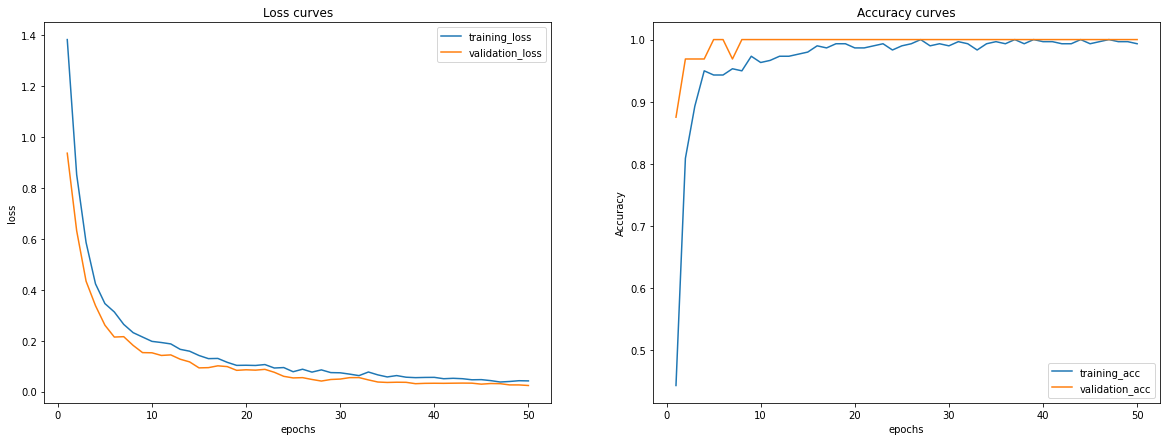

In [ ]:
def plot_loss_curves_densenet(history):
    
    '''
      returns seperate loss curves for training and validation metrics
    '''
    train_loss=history.history['loss']
    val_loss=history.history['val_loss']

    train_accuracy=history.history['accuracy']
    val_accuracy=history.history['val_accuracy']

    epochs=range(1,len(history.history['loss'])+1)
    plt.figure(figsize=(20,7))
  # plot loss data
    plt.subplot(1,2,1)
    plt.plot(epochs,train_loss,label="training_loss")
    plt.plot(epochs,val_loss,label="validation_loss")
    plt.title("Loss curves")
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
  # plt.show()

  # plot accuracy data
    plt.subplot(1,2,2)
    plt.plot(epochs,train_accuracy,label="training_acc")
    plt.plot(epochs,val_accuracy,label="validation_acc")
    plt.title("Accuracy curves")
    plt.xlabel('epochs')
    plt.ylabel('Accuracy')
    plt.legend()

plot_loss_curves_densenet(history)

### EfficientNetB0


In [ ]:
IMAGE_SIZE=(224,224)

train_data=tf.keras.preprocessing.image_dataset_from_directory(
    PATH_TRAIN,
    label_mode='categorical',
    image_size=IMAGE_SIZE
)
class_names=train_data.class_names
num_classes=len(class_names)
val_data=tf.keras.preprocessing.image_dataset_from_directory(
    PATH_VAL,
    label_mode='categorical',
    image_size=IMAGE_SIZE,
    
)
test_data=tf.keras.preprocessing.image_dataset_from_directory(
    PATH_TEST,
    label_mode='categorical',
    image_size=IMAGE_SIZE,
    shuffle=False
)

train_data_pf=train_data.prefetch(buffer_size=tf.data.AUTOTUNE)
val_data_pf=val_data.prefetch(buffer_size=tf.data.AUTOTUNE)
test_data_pf=test_data.prefetch(buffer_size=tf.data.AUTOTUNE)

Found 298 files belonging to 5 classes.
Found 68 files belonging to 5 classes.
Found 155 files belonging to 5 classes.


In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import layers,mixed_precision

#### EfficientB0

In [ ]:
#1 Define Data Augmentation Layer
data_augmentation=keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2,fill_mode='nearest'),
    # layers.Rescaling(scale=1.0/255)
],name='Data_Augmentation_Layer')

In [ ]:
#2 Create the model
mixed_precision.set_global_policy('mixed_float16')

inputs=layers.Input(shape=(224,224,3),name='input_layer')

base_model=keras.applications.efficientnet.EfficientNetB0(include_top=False)
base_model.trainable=False

x=data_augmentation(inputs)
x=base_model(x,training=False)

x=layers.GlobalAveragePooling2D(name='Global_Average_Pool_2D')(x)
num_classes=len(train_data.class_names)
outputs=layers.Dense(num_classes,activation='softmax',dtype=tf.float32,name="Output_layer")(x)

model=keras.Model(inputs,outputs,name="model")

In [ ]:
#3 Compile the model
model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy']
)

#4 model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 Data_Augmentation_Layer (Se  (None, 224, 224, 3)      0         
 quential)                                                       
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 Global_Average_Pool_2D (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 Output_layer (Dense)        (None, 5)                 6405      
                                                                 
Total params: 4,055,976
Trainable params: 6,405
Non-trainable

In [ ]:
#5 Fit the model
EPOCHS=5
history_of_model=model.fit(
    train_data_pf,
    epochs=EPOCHS,
    steps_per_epoch=int (0.1*len(train_data_pf)),
    validation_data=val_data_pf,
    validation_steps=len(val_data_pf),   
)

Epoch 1/5
1/1 [==============================] - 9s 9s/step - loss: 1.9021 - accuracy: 0.1250 - val_loss: 1.6725 - val_accuracy: 0.1618
Epoch 2/5
1/1 [==============================] - 0s 359ms/step - loss: 1.7451 - accuracy: 0.1250 - val_loss: 1.5858 - val_accuracy: 0.1912
Epoch 3/5
1/1 [==============================] - 0s 369ms/step - loss: 1.6422 - accuracy: 0.2812 - val_loss: 1.5038 - val_accuracy: 0.2647
Epoch 4/5
1/1 [==============================] - 0s 331ms/step - loss: 1.4201 - accuracy: 0.4688 - val_loss: 1.4266 - val_accuracy: 0.4412
Epoch 5/5
1/1 [==============================] - 0s 375ms/step - loss: 1.4837 - accuracy: 0.2812 - val_loss: 1.3497 - val_accuracy: 0.5735


In [ ]:
#6 model_0 result
model_0_result=model.evaluate(test_data_pf)
model_0_result

5/5 [==============================] - 1s 97ms/step - loss: 1.3141 - accuracy: 0.6065


[1.314125657081604, 0.6064516305923462]

In [ ]:
def plot_loss_curves(history):
    
    '''
      returns seperate loss curves for training and validation metrics
    '''
    train_loss=history.history['loss']
    val_loss=history.history['val_loss']

    train_accuracy=history.history['accuracy']
    val_accuracy=history.history['val_accuracy']

    epochs=range(1,len(history.history['loss'])+1)
    plt.figure(figsize=(20,7))
  # plot loss data
    plt.subplot(1,2,1)
    plt.plot(epochs,train_loss,label="training_loss")
    plt.plot(epochs,val_loss,label="validation_loss")
    plt.title("Loss curves")
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
  # plt.show()

  # plot accuracy data
    plt.subplot(1,2,2)
    plt.plot(epochs,train_accuracy,label="training_acc")
    plt.plot(epochs,val_accuracy,label="validation_acc")
    plt.title("Accuracy curves")
    plt.xlabel('epochs')
    plt.ylabel('Accuracy')
    plt.legend()

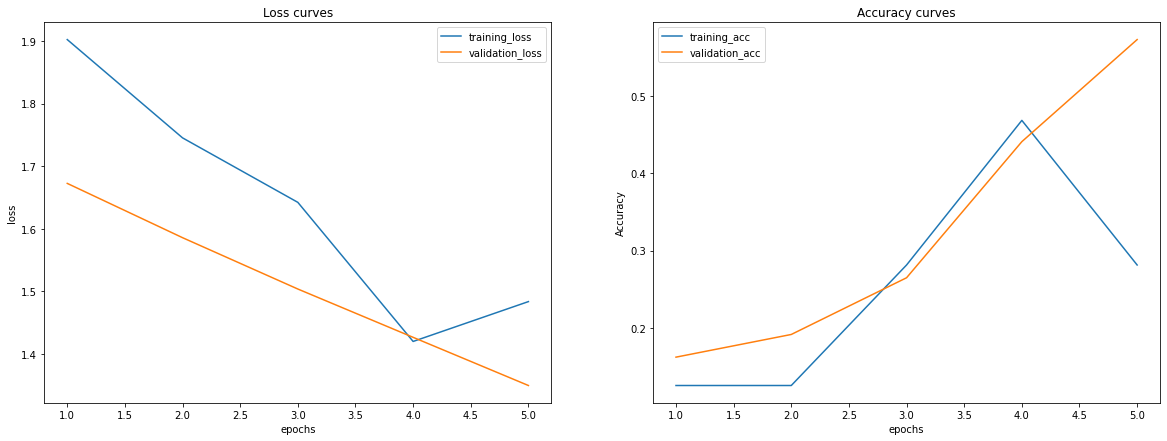

In [ ]:
plot_loss_curves(history_of_model)